# Correcting brightness nonuniformity with tophat filters

Thresholding, usually the first image segmentation technique to be taught, labels individual pixels based on intensity. No information
from a surrounding region is used.

Basic concepts of segmentation, including thresholding, for skimage are introduced [here](https://scikit-image.org/docs/0.14.x/user_guide/tutorial_segmentation.html) and [here](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_niblack_sauvola.html) and [here](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/solutions/4_segmentation.ipynb)

In this tutorial we'll focus on extending the classical thresholding techniques via processes that correct nonuniformity. Brightness nonuniformity is a common problem in many forms of imaging, with varying causes. Having a collection of tools to help deal with nonuniformity can simplify subsequent analysis steps considerably.

## Recap

The _page_ data, shown below, contains some scanned text and the aim is to select a threshold that separates printing from paper (dark from light). The tutorials linked above introduce manual selection, selection based on histograms, and adaptive thresholding, where a different threshold is selected for each pixel based on parameters of the local neighborhood. The results of these methods are shown at the end of the tutorial for reference.

The approach we will introduce is similar to adaptive filtering, but is built using existing filtering procedures to which the manual or histogram approaches can be applied


# Set up libraries and display functions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure
import skimage.morphology as morph


def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax


# Load and display the test data

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

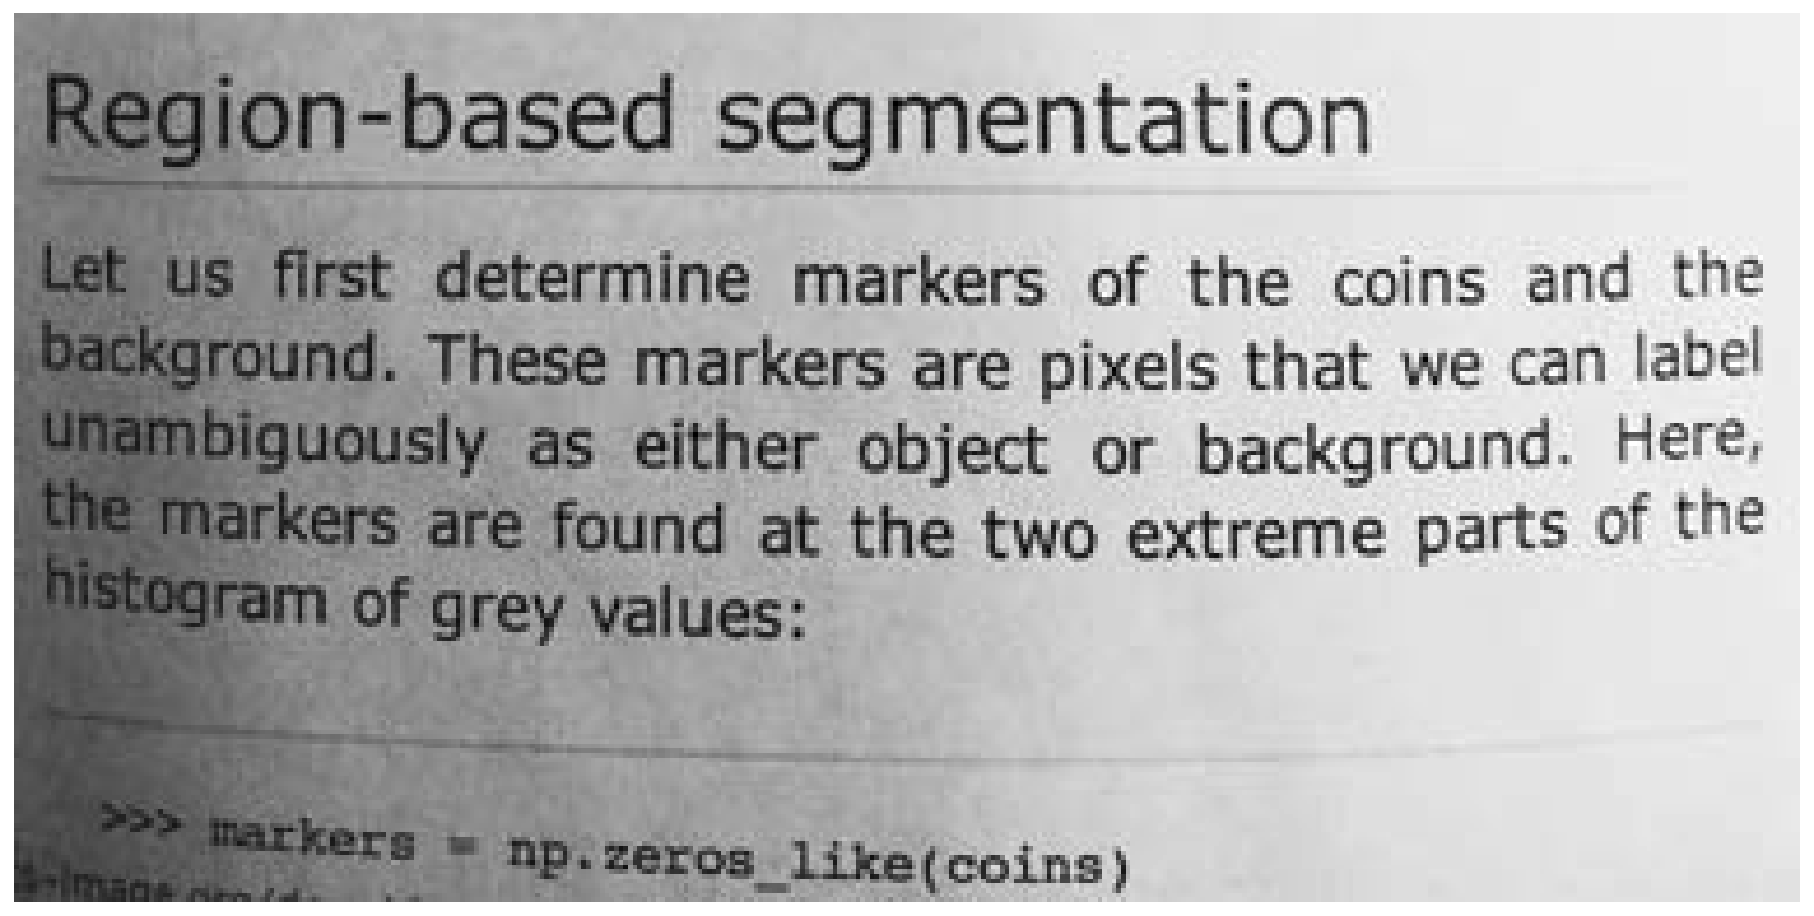

In [2]:
text = data.page()
image_show(text)

# Background estimation

The lower left of the image above is clearly darker than the top right. In this case it is impossible to select a threshold that retains all the text on the right while leaving the background in the lower left clear - see [Manual threshold](#manual). The [histogram](#automatic) methods have the same problem, with varying levels of blackness in the lower left. The [adaptive](#adaptive) methods produce more uniform results, possibly with other artifacts.

An alternative to the adaptive approach is to estimate the background intensity and remove it.

This approach can work if the following conditions are met:

1. The relative brightness of the objects of interest and the background is consistent - in this example the text is always darker than the local bacground.

1. The size of the foreground features don't vary too much

A classical way to estimate background brightness and remove it is via a morphological _tophat_ filter. A _black tophat_ filter removes bright backgrounds (enhancing dark objects) while a _white tophat_ filter removes dark backgrounds. A black tophat filter is constructed by subtracting the image from a morphologial closing of the image. A white tophat filter subtracts a morphological opening from the image. As described elsewhere, a morphological closing is a dilation (shrinking dark features) followed by an erosion (shrinking bright features).

_skimage_ provides tophat filter functions, but we will begin by looking at the _closing_ operation to understand the size of kernel we need and explore speed tradeoffs.




### Filter size selection

Lets start with a tiny filter, defined by the _selem_ argument, and work our way up. We're using rectangle filters because they are much faster, for reasons we'll get to later.

We can still see some text below, so this filter is too small.

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

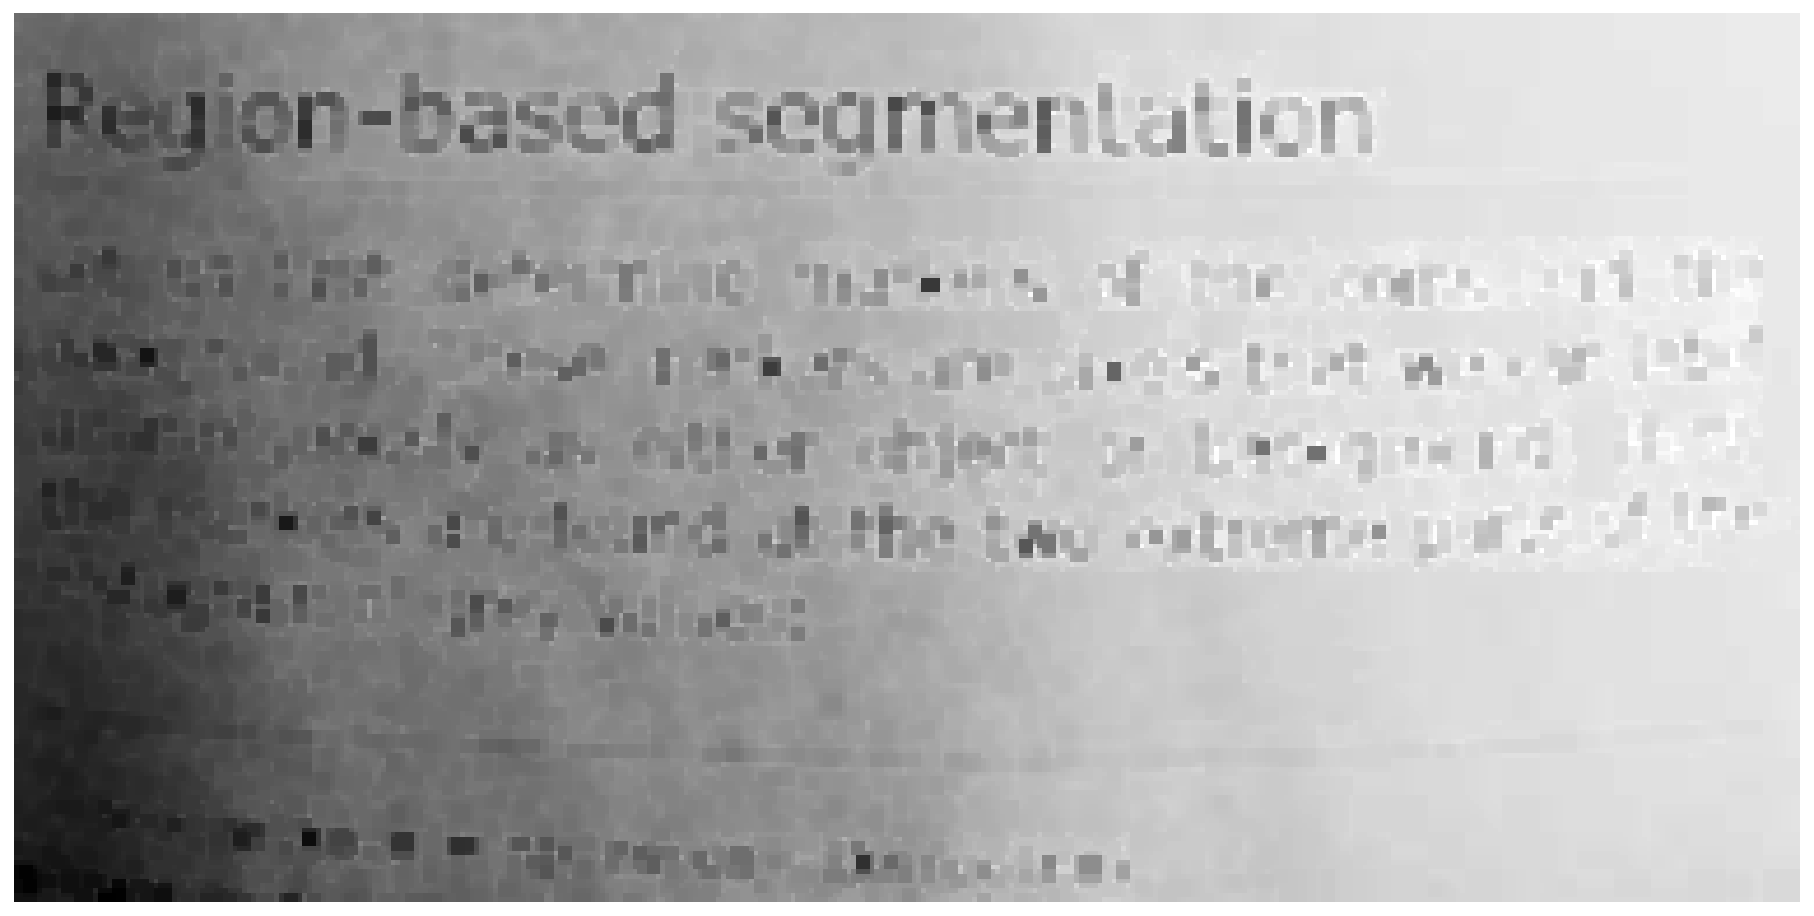

In [12]:
image_show(morph.closing(text, selem=morph.rectangle(3,3)))

This time we'll try a much bigger filter

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

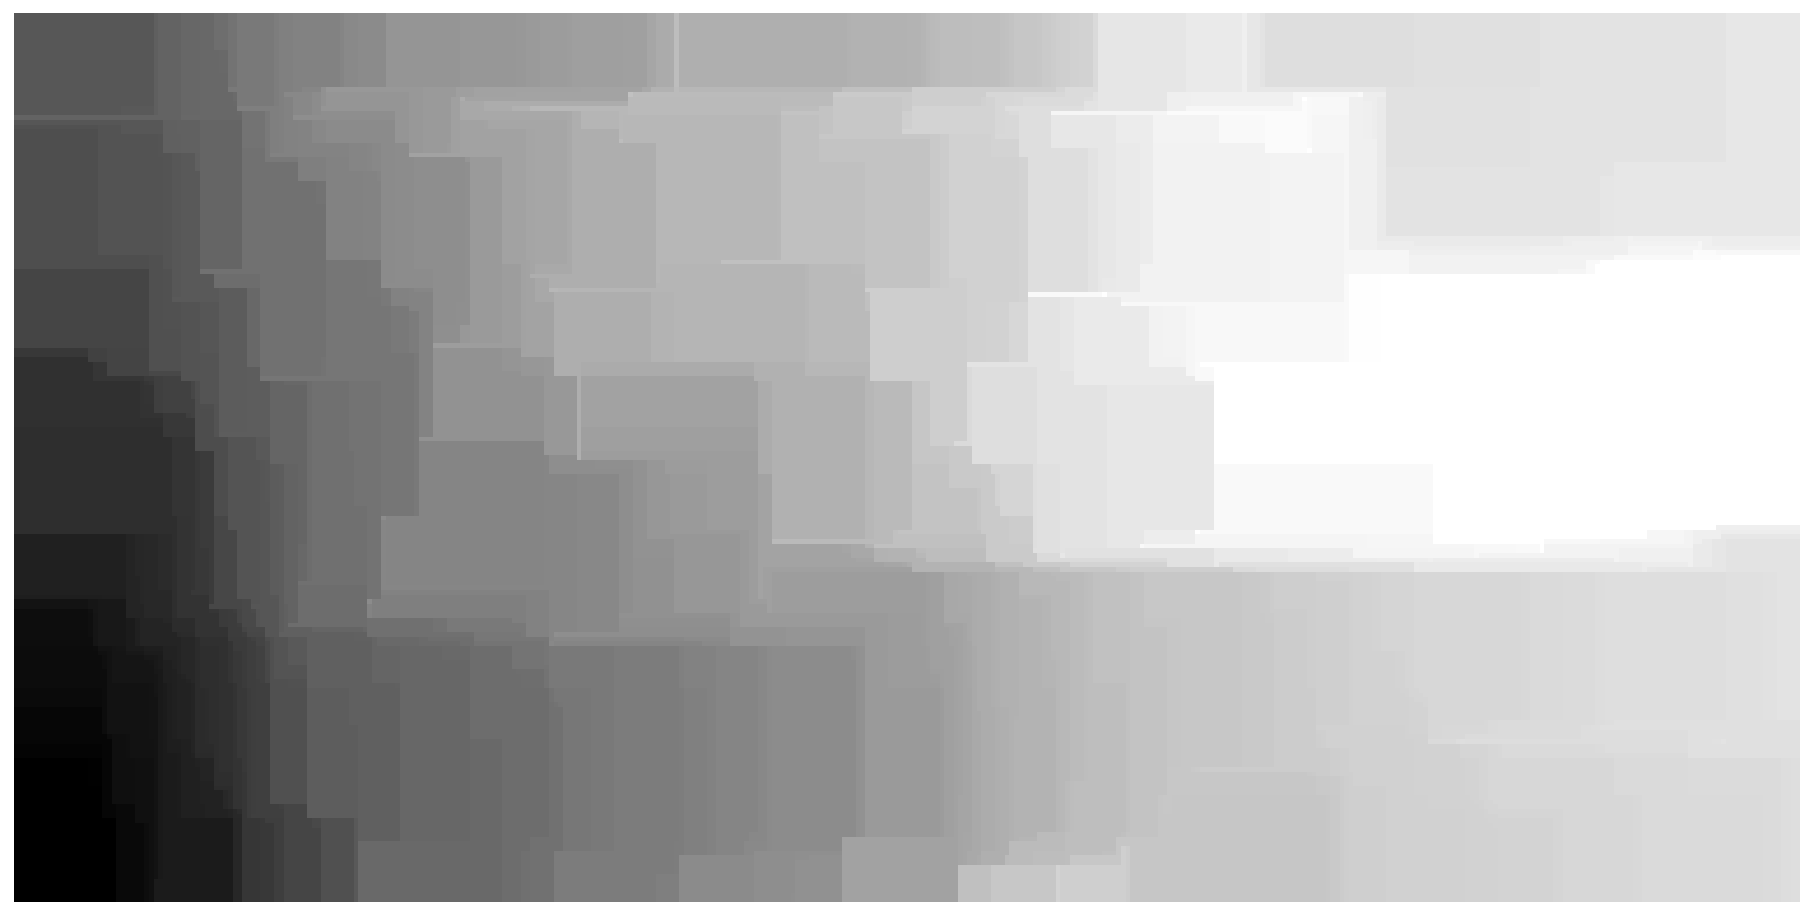

In [13]:
image_show(morph.closing(text, selem=morph.rectangle(31,31)))

This looks pretty good - there's no sign of the text and the brightness pattern is what we'd expect. Now for the black tophat version:

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

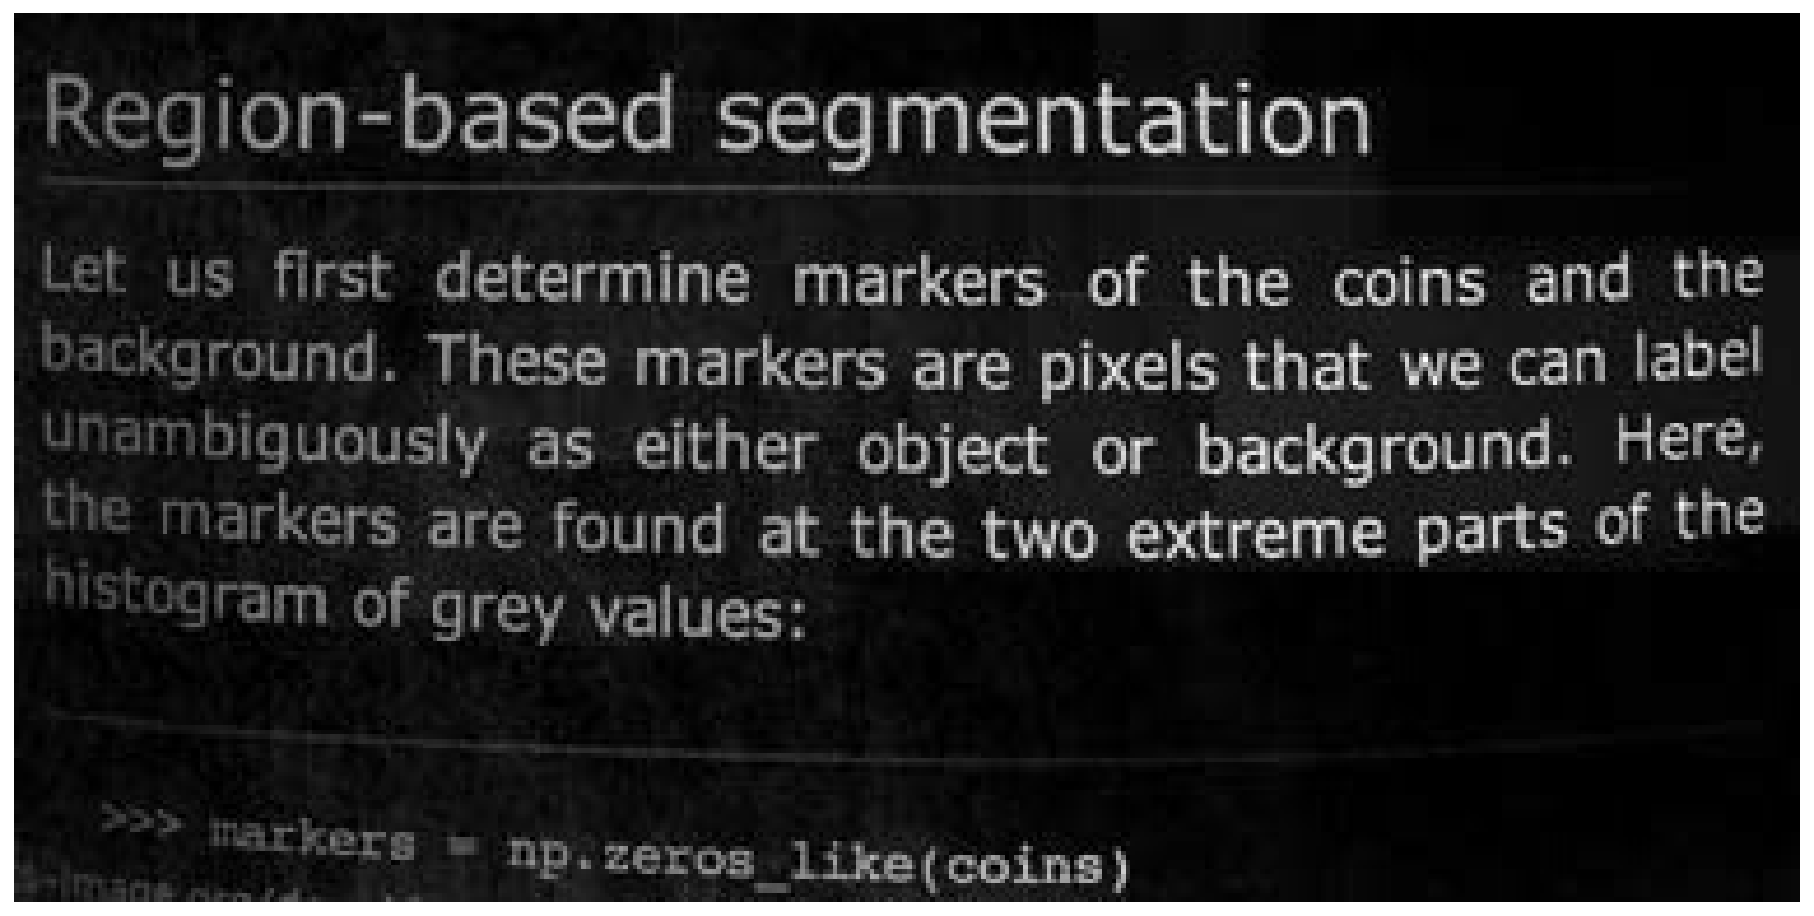

In [15]:
bth = morph.black_tophat(text, selem=morph.rectangle(31,31))
image_show(bth)

Some variation in the foreground intensity is visible - text on the right is brighter than the text on the left, but we don't care about this provided we can now select a resonable threshold. Lets see how the automated methods perform:

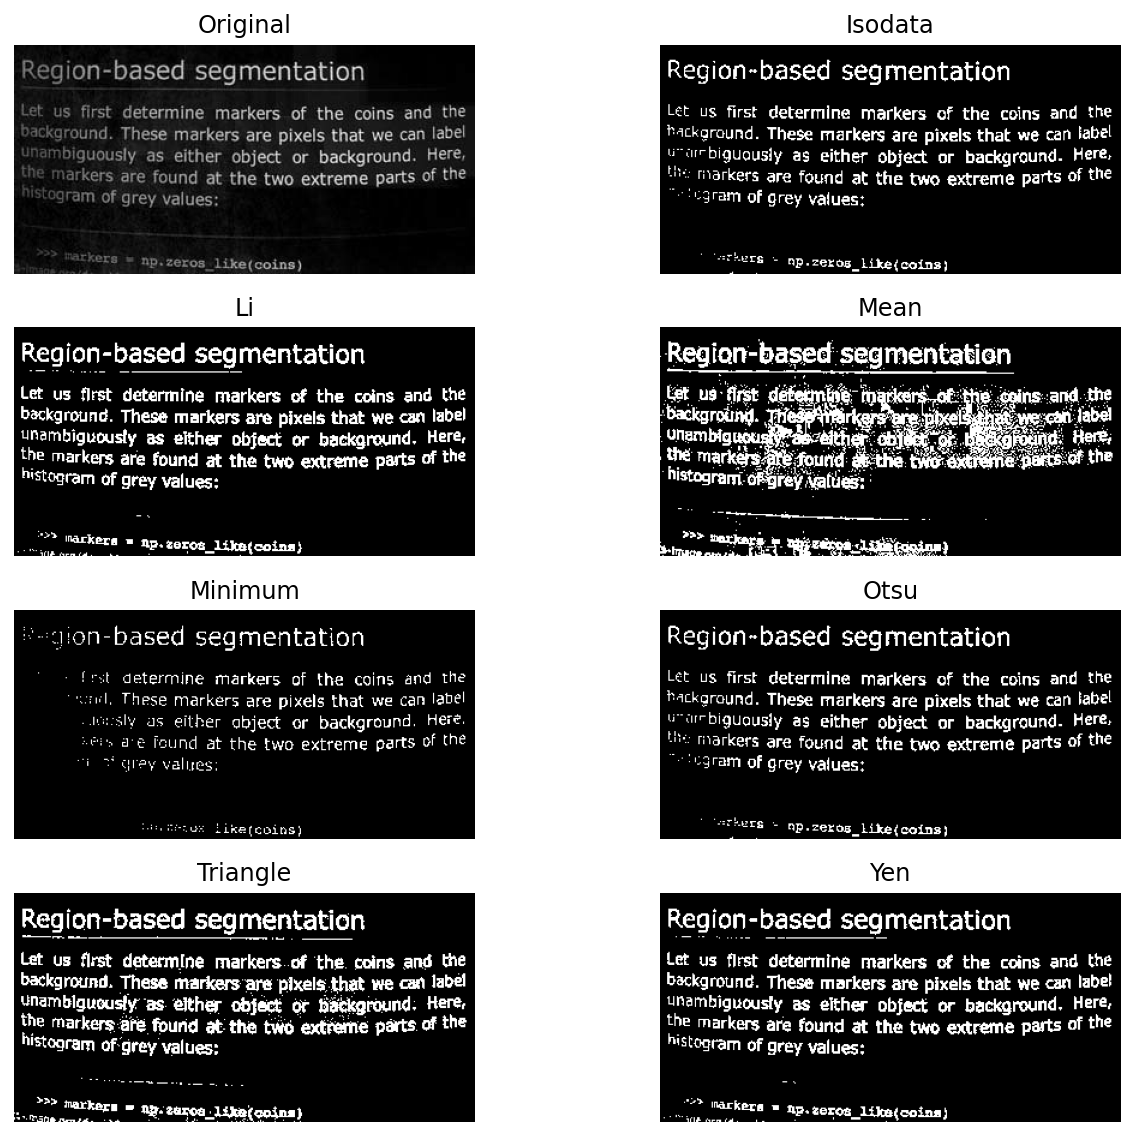

In [16]:
fig, ax = filters.try_all_threshold(bth, figsize=(10, 8), verbose=False)
plt.show()

Several of the automated methods now perform in what is probably an acceptable fashion, and possibly just as well as the specialised adaptive methods below.

Another idea that you may explore, depending on the data, is matching the shape of the filter to the characteristics of the brightness variation. In many situations the brightness is highest in the middle and drops towards the edges, so there isn't much to be gained by changing the filter aspect ratio. However in the text example, the brightness gradient is stronger left to right than top to bottom, so we might like a structuring element that is higher than it is wide.

# Potential problems

This approach can fail if the background parts of the image have unusual noise characteristics, such as _salt_ noise consisting of scattered very bright pixels. Such noise, if frequent enough, could lead to over-estimation of background intensity.

# Summary

Tophat filters are very useful for this class of problems, and quite simple and intuitive to use. Choose a filter that is large enough to remove your largest feature and then proceed with conventional thresholding - no need to write specialised adaptive filters. The process isn't especially sensitive to the filter size, provided it isn't too small, and this usually makes it easy to select something useful - don't be afraid to try a largish structuring element to start with.

Tophat filters are fast, simple and useful for this class of problems. Other approaches to estimating nonuniformity are possible. For example, a large median filter might be more appropriate if the objects of interest are both brighter and darker than the background. However this requires background pixes occupy more than 50% of the kernel. Other options, that are more computationally complex, have been developed for MRI where there isn't a useful background to subtract. The N3/N4 family of methods are examples.

# Notes on speed

In these examples I chose a rectangular filter. Straight edged filters are often considered undesirable because they can leave visible artifacts in the form of corners and straight lines, and these are visible in the estimated background above. 

However the gain is speed. The larger filter in the code above runs in the same time as the smaller one, despite the kernel having 100 times as many pixels. Rectangular morphological filters can be decomposed into a pair of lines, and there are fast algorithms that allow erosions and dilations along lines to be computed in constant time.

This means we can explore solutions to problems that use morpholgical filters and large rectangular structuring elements without having to worry about speed.


The two cells below illustrate this with crude timing. The first cell uses a rectangular structuring element and the elapsed time remains constant, while the second cell uses a disk structuring element and the largest time is over 100 times the smallest - i.e complexity is proportional to the number of pixels in the structuring element.

In [23]:
# time rectanguler structuring elements
import time

elapsed = list()
for sz in [3, 11, 31]:
   tic=time.perf_counter()
   a = morph.closing(text, selem=morph.rectangle(sz,sz))
   elapsed.append(time.perf_counter()-tic)

print(elapsed)

[0.005178621970117092, 0.004622356966137886, 0.004363359999842942]


In [24]:
# time for circular structuring element
elapsed = list()
for sz in [3, 11, 31]:
   tic=time.perf_counter()
   a = morph.closing(text, selem=morph.disk(sz))
   elapsed.append(time.perf_counter()-tic)

print(elapsed)
print(elapsed[2]/elapsed[0])

[0.009529172093607485, 0.11407211888581514, 1.1505181760294363]
120.73642544468744


# Review of threshold methods



<a id='manual'></a>
## Manual threshold 

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

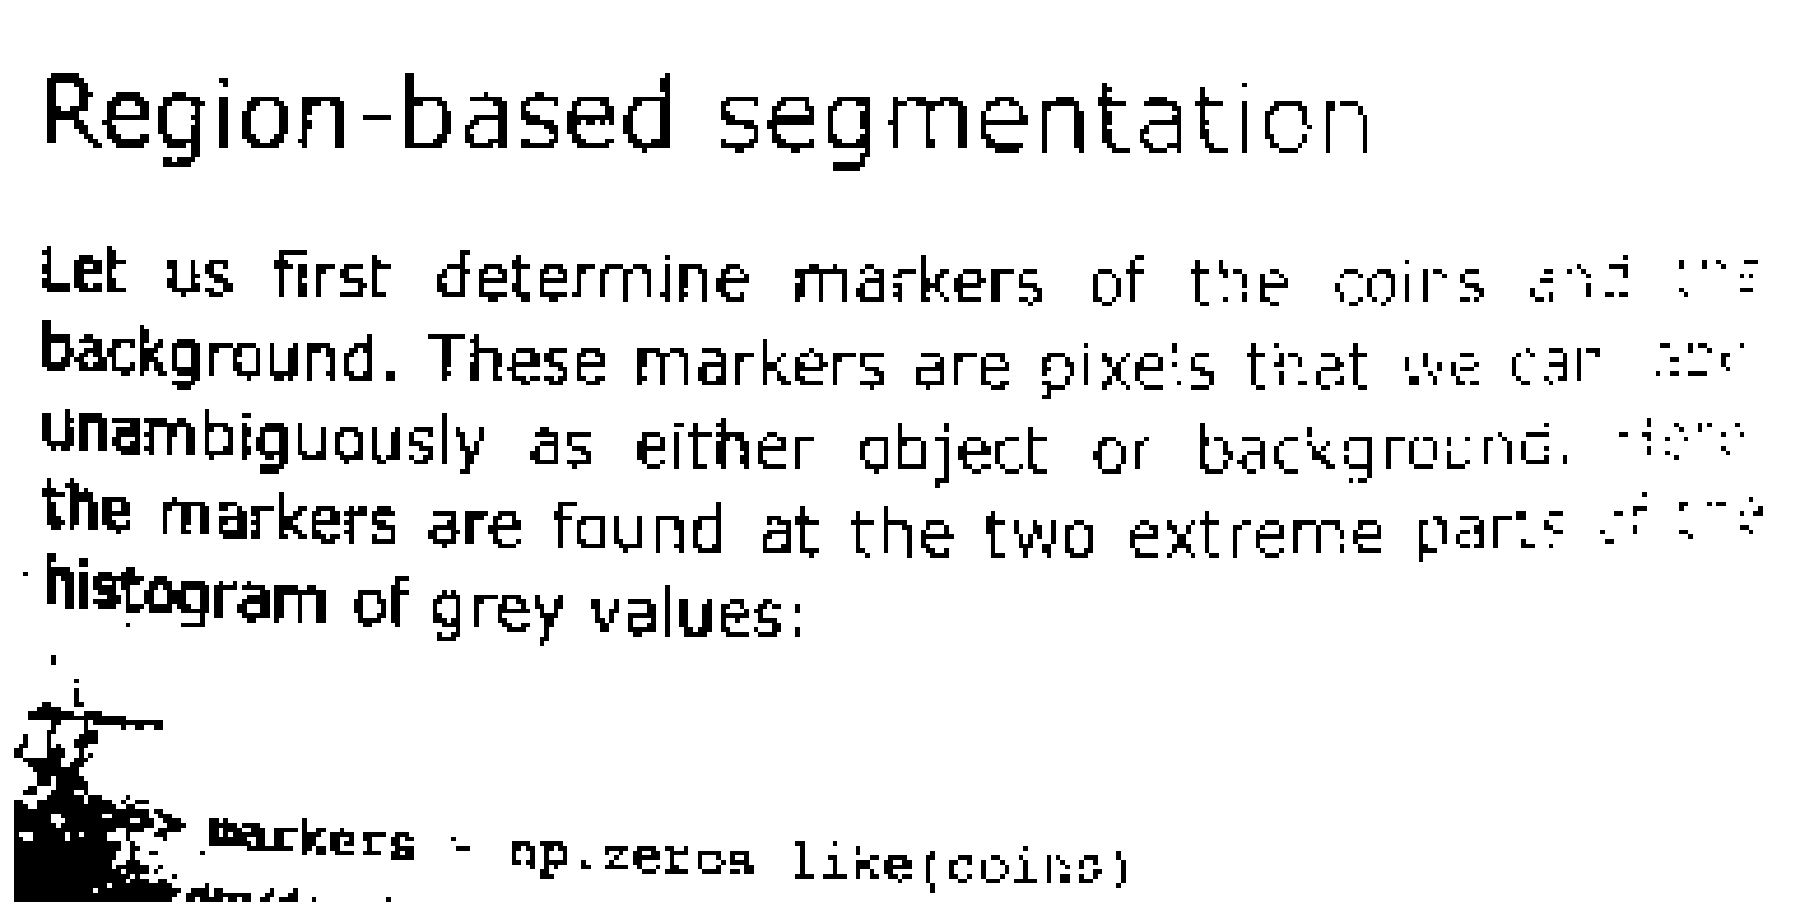

In [4]:
image_show(text>80)

<a id='automatic'></a>

## Automatic threshold estimation using histograms

All of the examples below compute a global threshold by analysing the histogram. The methods make different assumptions about brightness distributions and are therefore function best in different circumstances.


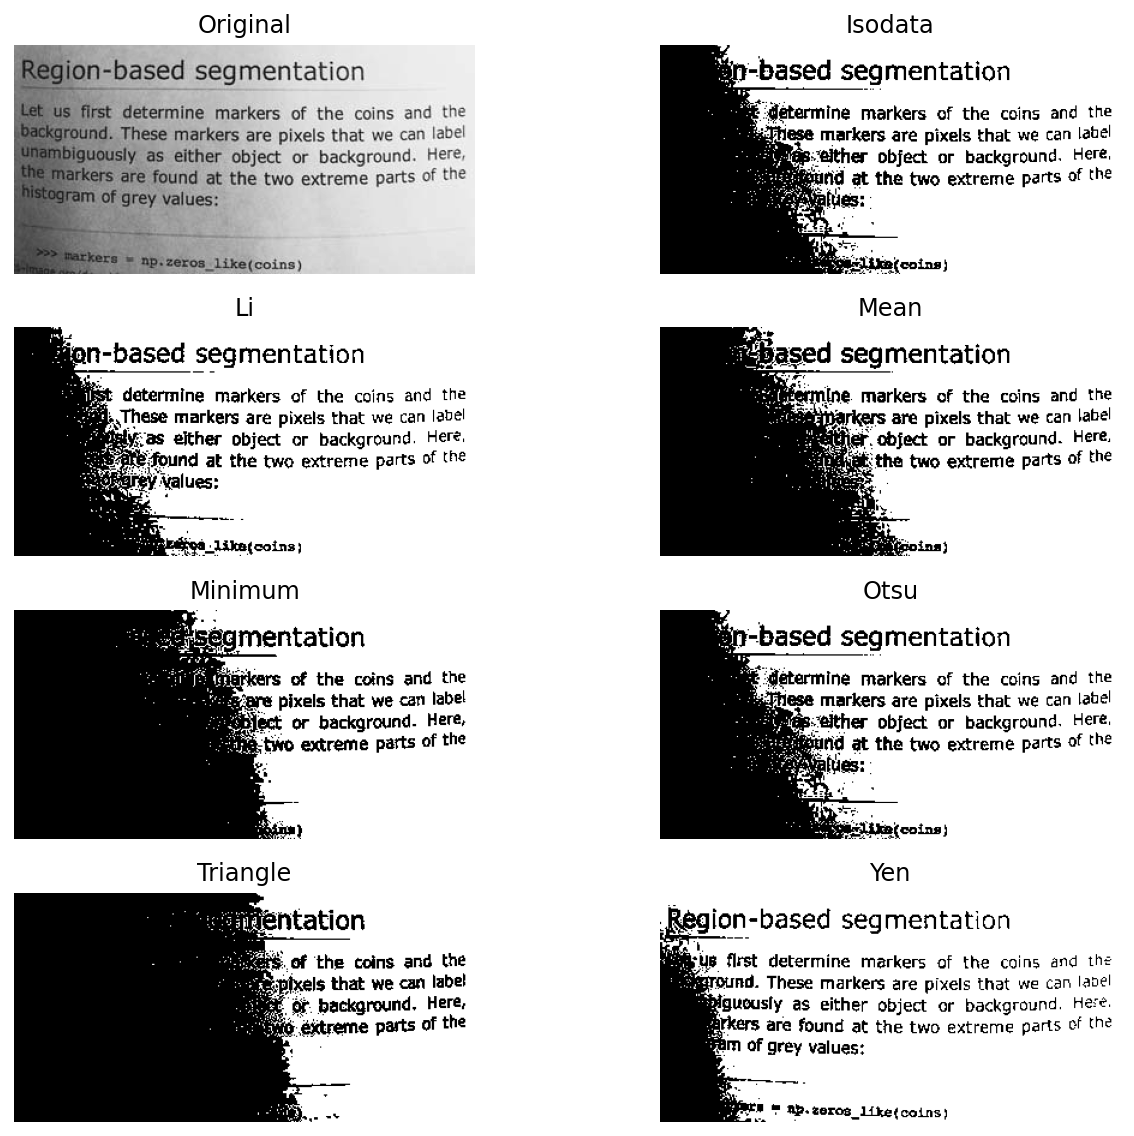

In [5]:
fig, ax = filters.try_all_threshold(text, figsize=(10, 8), verbose=False)
plt.show()


<a id='adaptive'></a>

## Adaptive thresholds

These methods use information from local neighbourhoods to compute a local threshold.

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

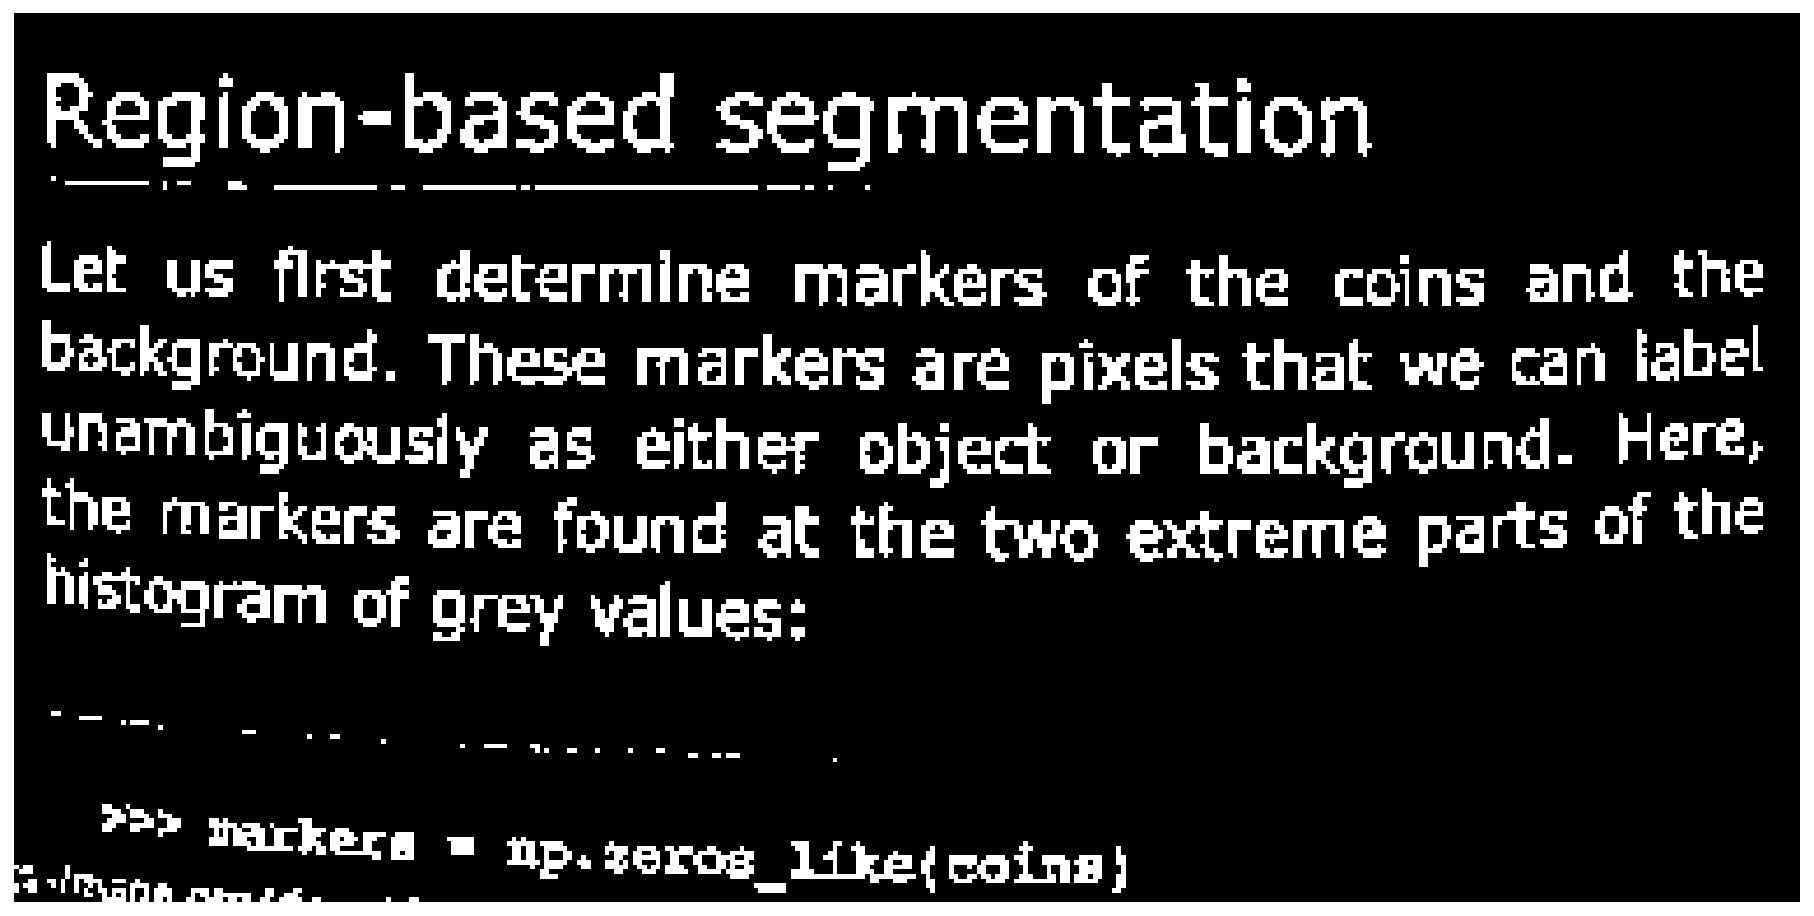

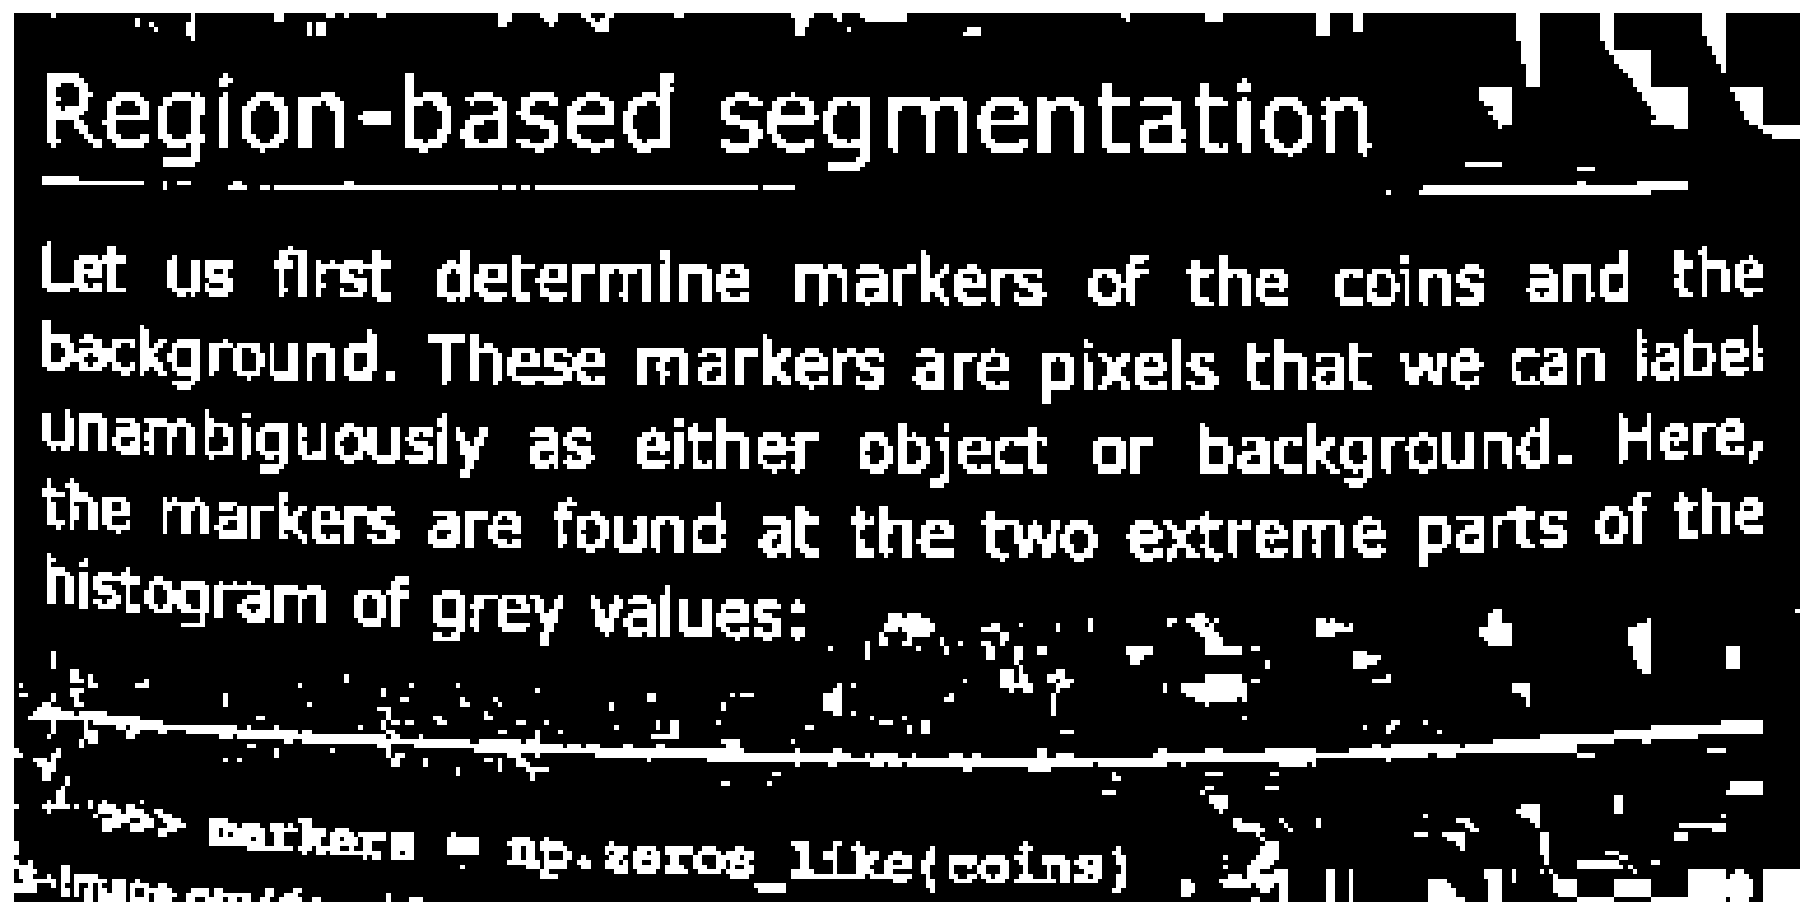

In [10]:
text_threshold = filters.threshold_sauvola(text, window_size=15, k=0.2)

image_show(text < text_threshold);

text_threshold = filters.threshold_niblack(text, window_size = 25, k=0.6)
image_show(text < text_threshold)
